In [603]:
import cPickle as pickle
import itertools
import json
import scipy as sp
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import time
from functools import partial
from operator import itemgetter

from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.grid_search import GridSearchCV
from sklearn import cross_validation, linear_model

import matplotlib.pyplot as plt

%matplotlib inline
#plt.rc('figure', figsize=(10, 6))

## 1. Load Prediction of test data and CV-predictoin of train data

In [604]:
path_to_results = 'C:/Users/HZ/Dropbox/Bio_Physics_JailBreak/Kaggle/Final Prediction/'


test_ID = pickle.load(open(path_to_results+'xtest_ID.pkl','rb'))    
y = pickle.load(open(path_to_results+'ytrain2.dat','rb'))  # ground-truth label of training data
print(y.shape)

results=[#"pa-283_","pa-335_","pa-0p75277_wl_",
#         "sgd-283_","sgd-335_",'sgd-0p768996_wl_','sgd-0p770277_wl_',
#         'sgd_0p784555_wl_',
         'sgd_0p771702_wl_',
         'sgd_0p770356_wl_','sgd_0p769531_wl_',
         'svm-0p752773_wl_',
#         "svm-283_","svm-335_",
         "rf-335_","rf-all_",
         "xgb-665_","xgb-933_","xgb-all_","xgb_0p770751_wl_",
        "xgb_lr_0p777824_wl_","xgb_lr_0p777125_50Segments_wl_","xgb_lr_0p776415_wl_",
         "xgb_0p784886_wl_","xgb_0p785604_wl_","xgb_0p785120_wl_","xgb_0p784916_wl_",
        "xgb_0p785155_wl_","xgb_0p785468_wl_","xgb_0p785787_wl_","xgb_0p785890_wl_","xgb_0p786040_wl_","xgb_0p786290_wl_",
#        "xgb_0p806151_wl_",
        "xgbmeta_0p793611_wl_",
        "xgbmeta_0p793971_wl_"]

# addition models from Saifeng
model_name1  = 'xgb_Oct192015134751_AUC_0p787695_sl_'
model_name2  = 'xgb_Oct192015065533_AUC_0p787632_sl_'
model_name3  = 'xgb_Oct192015133017_AUC_0p787608_sl_'
model_name4  = 'xgb_Oct192015101525_AUC_0p787437_sl_'
model_name5  = 'xgb_Oct192015120324_AUC_0p787252_sl_'
model_name6  = 'xgb_Oct192015085532_AUC_0p787197_sl_'
model_name7  = 'xgb_Oct192015040605_AUC_0p786733_sl_'
model_name8  = 'xgb_Oct192015051026_AUC_0p786338_sl_'
model_name9  = 'xgb_Oct192015120134_AUC_0p785606_sl_'
model_name10 = 'xgb_Oct192015052747_AUC_0p781263_sl_'
model_name11 = 'xgb_Oct192015065922_AUC_0p780004_sl_'
model_name12 = 'xgb_Oct192015154017_AUC_0p787790_sl_'
model_name13 = 'meta_xgb_Oct192015184228_AUC_0p794324_sl_'
model_name14 = 'meta_xgb_Oct192015184936_AUC_0p794619_sl_'
model_name15 = 'meta_xgb_Oct192015185918_AUC_0p794108_sl_'

model_saifeng=[model_name1,model_name2,model_name3,model_name4,model_name5,
               model_name6,model_name7,model_name8,model_name9,model_name10,
               model_name11,model_name12,model_name13,model_name14,model_name15]
results.extend(model_saifeng)

nameypreds_train = 'ypredtrain.pkl'
nameypreds_test = 'ypredtest.pkl'

preds_train=[]
preds_test =[]

for i, model in enumerate(results):
    ypred_train = list(pickle.load(open(path_to_results + model + nameypreds_train, 'rb')))
    print('Model-%d: The min and max of model %s ypred_train is: %f, %f'%(i+1, model,np.array(ypred_train).min(),np.array(ypred_train).max()))
    print('Model-%d: The AUC score for model %s is: %f\n'%(i+1, model,metrics.roc_auc_score(y, ypred_train)))
    preds_train.append(ypred_train)
    preds_test.append(list(pickle.load(open(path_to_results + model + nameypreds_test, 'rb'))))
        
preds_train=np.array(preds_train).T
preds_test=np.array(preds_test).T    
print(preds_train.shape, preds_test.shape)

(145231L,)
Model-1: The min and max of model sgd_0p771702_wl_ ypred_train is: 0.002001, 0.987034
Model-1: The AUC score for model sgd_0p771702_wl_ is: 0.771702

Model-2: The min and max of model sgd_0p770356_wl_ ypred_train is: 0.003360, 0.976353
Model-2: The AUC score for model sgd_0p770356_wl_ is: 0.770356

Model-3: The min and max of model sgd_0p769531_wl_ ypred_train is: 0.021350, 0.989736
Model-3: The AUC score for model sgd_0p769531_wl_ is: 0.769532

Model-4: The min and max of model svm-0p752773_wl_ ypred_train is: 0.000000, 0.950000
Model-4: The AUC score for model svm-0p752773_wl_ is: 0.752773

Model-5: The min and max of model rf-335_ ypred_train is: 0.001132, 0.897290
Model-5: The AUC score for model rf-335_ is: 0.770027

Model-6: The min and max of model rf-all_ ypred_train is: 0.001167, 0.892383
Model-6: The AUC score for model rf-all_ is: 0.768094

Model-7: The min and max of model xgb-665_ ypred_train is: 0.017837, 0.931054
Model-7: The AUC score for model xgb-665_ is: 0

In [605]:
#preds_train = pd.DataFrame(preds_train)
#preds_test  = pd.DataFrame(preds_test)
#y = pd.Series(y)

In [606]:
class ModelEnsembler(object):
    """
    Implement stacking to combine several models.
    There are several methods to do stacking.
    1. BaggingEnsembler: take the simple average of level-0 predictions on the test set
    2. LSEnsembler: linear regression to minimize the least square lost of a linear combination of model predictions on the train set. 
             the optimized coefficients are used to combine model predictions on the test set.
    3. AUCEnsember: again, linear combination of model predictions on the train set. 
                    But we search for the coefficients to maximize AUC score on the train set.
                    The optimized coefficients are further used to combine predictions on the train set.
    4. StackingEnsembler: use a level-1 model to train the level-0 predictions on the train set. 
                          Then use the trained level-1 model to compute predictions on the test set.               
    """
    def __init__(self,generalizer=None):
        self.coef_ = 0
        self.generalizer = linear_model.RidgeCV(alphas=np.linspace(0, 1000), cv=10) # level-1 model
        
    # 1. BaggingEnsembler   
    def Bagging(self, preds_test):  # preds_test in the form of N x M, N: # of samples, M: # of level-0 model preds.
        return np.mean(preds_test, axis=1)   # average over M model preds
    
    # 2. LSEnsembler
    def fit_LS(self, X, y): # X = preds_train in the form of N x M
        self.coef_ = sp.optimize.nnls(X, y)[0] #argmin_w||Xw-y||_2 solver for w
        self.coef_ = np.array(map(lambda x: x/sum(self.coef_), self.coef_)) # normalized

    def predict_proba(self, X):  # X = preds_test in the form of N x M 
        return sp.dot(X, self.coef_)
    
    def score(self, y, ypreds):  # AUC score
        fpr, tpr, _ = roc_curve(y, ypreds)
        return auc(fpr, tpr)
    
    def _auc_loss(self, coef, X, y):
        fpr, tpr, _ = roc_curve(y, sp.dot(X, coef))
        return -auc(fpr, tpr)
    
    # 3. AUCEnsembler
    def fit_AUC(self, X, y):# X = preds_train, find coef to maximize AUC
        lr = linear_model.LinearRegression()
#        lr = linear_model.LinearRegression(fit_intercept=False)

                
        auc_partial = partial(self._auc_loss, X=X, y=y)  # return a new function of coef
#       initial_coef = lr.fit(X, y).coef_                # initial guess
        initial_coef = [1/float(X.shape[1])]*X.shape[1]
        print ('Initial coefficient of AUC_fit:')
        print(initial_coef)
        bnds = tuple([(0,1) for i in range(len(initial_coef))])
        
        
        #res = minimize(auc_partial, initial_coef,  constraints=cons, method='SLSQP', options={'disp': True})
        res = minimize(auc_partial, initial_coef,  bounds=bnds, method='SLSQP', options={'disp': True})
        self.coef_=res.x
        
    # 4. StackingEnsembler: train level-1 model on level-0 predictions of train set, then compute predictions of test set
    def stackingEnsembler(self, preds_train, y, preds_test):
        self.generalizer.fit(preds_train, y)
        print('The coef from stacking is :')
        print(self.generalizer.coef_)
        print ('The optimal alpha is %d'%self.generalizer.alpha_)
        return self.generalizer.predict(preds_test)

In [607]:
# generate submission files
def save_results(test_ID, predictions, filename):
    """Given a vector of predictions, save results in CSV format."""
    with open(filename, 'w') as f:
        f.write("ID,target\n")
        for i in range(len(test_ID)):
            f.write("%d,%f\n" % (test_ID[i], predictions[i]))

## 2. Model Ensembling

In [608]:
preds_train.shape

(145231L, 40L)

In [609]:
preds_train[100,1]

0.16845507694037137

### 2.0 Greedy Bagging with replacememnt

In [610]:
def greedy_bagging(preds_train, preds_test, y, nth=20):
    m,n = preds_train.shape
    bag_count=np.zeros(n) # to store the count of each model
    ytrain_accum = np.zeros(m) # to store the sum of selected ypred_train
    
    hist_auc=[]
    
    num_sel_models = 0
    best_auc = -9999
    
    true_best = -9999
    
    yauc = np.zeros(n)
    ytemp = np.zeros((m,n))
    
    while num_sel_models<nth:
        for i in range(n):
            ytemp[:,i] = (ytrain_accum*num_sel_models + preds_train[:,i])/float(num_sel_models+1)           
            yauc[i] = metrics.roc_auc_score(y, ytemp[:,i])
        
        max_ind = np.argmax(yauc)
        print('The best auc in round %d: %9.7f'%(num_sel_models,yauc[max_ind]))
        
        if yauc[max_ind]>true_best:
            true_best=yauc[max_ind]
            count_best=np.copy(bag_count)
                
        if yauc[max_ind]>best_auc*0.95:
            best_auc = yauc[max_ind]
            ytrain_accum = ytemp[:,max_ind]
            num_sel_models += 1
            bag_count[max_ind] += 1
            
            hist_auc.append(best_auc)
        else:
            break
    
    plt.gca()
    plt.plot(range(len(hist_auc)), hist_auc, 'ro--')
    plt.legend(loc='best',fontsize='medium')
    plt.xlabel('# of models')
    plt.ylabel('AUC score')
    plt.ylim([min(hist_auc) - .001, max(hist_auc) + .001])

    str1=time.strftime("%b%d%Y_%H%M%S", time.localtime())
    
    plt.savefig(path_to_results+'greedy-model-ensembling_'+str1+'.png')
    plt.show()
    
    return np.dot(preds_test,bag_count/float(num_sel_models)), bag_count, true_best, count_best,hist_auc

The best auc in round 0: 0.7946198
The best auc in round 1: 0.7956130
The best auc in round 2: 0.7956625
The best auc in round 3: 0.7957415
The best auc in round 4: 0.7957617
The best auc in round 5: 0.7957709
The best auc in round 6: 0.7957957
The best auc in round 7: 0.7958090
The best auc in round 8: 0.7958135
The best auc in round 9: 0.7958072
The best auc in round 10: 0.7957900
The best auc in round 11: 0.7957968
The best auc in round 12: 0.7958109
The best auc in round 13: 0.7958157
The best auc in round 14: 0.7958179
The best auc in round 15: 0.7958138
The best auc in round 16: 0.7958104
The best auc in round 17: 0.7958143
The best auc in round 18: 0.7958199
The best auc in round 19: 0.7958157
The best auc in round 20: 0.7958162
The best auc in round 21: 0.7958156
The best auc in round 22: 0.7958196
The best auc in round 23: 0.7958185
The best auc in round 24: 0.7958177
The best auc in round 25: 0.7958170
The best auc in round 26: 0.7957798
The best auc in round 27: 0.7957061
Th

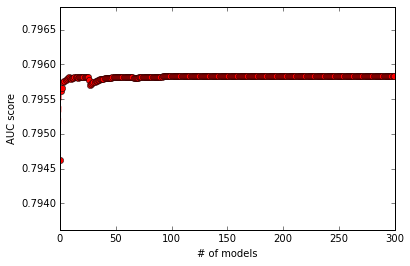

In [611]:
start_time=time.clock()

y_greedybag, bag_count, true_best, count_best,hist_auc = greedy_bagging(preds_train, preds_test, y, nth=10)

In [612]:
total_time=time.clock()-start_time
print('Completed Model Stacking')
print('Total running time is %d seconds\n' %total_time)

Completed Model Stacking
Total running time is 1753 seconds



In [613]:
print(bag_count)
print('The best auc is %9.7f with bag_count'%true_best)
print(count_best)

[   1.    0.    0.    0.    0.    4.    4.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    3.   39.
   62.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.    6.
    0.   26.  105.   49.]
The best auc is 0.7958310 with bag_count
[  1.   0.   0.   0.   0.   3.   2.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.  26.  43.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   4.   0.  16.  71.  35.]


In [614]:
num_models=np.array(count_best).sum()
print(num_models)

203.0


In [615]:
for i, model in enumerate(results):
    print('Model-%d: %s appears:'%(i+1, model))
    print('       %d times in final %d ensembles\n'%(count_best[i], num_models))

Model-1: sgd_0p771702_wl_ appears:
       1 times in final 203 ensembles

Model-2: sgd_0p770356_wl_ appears:
       0 times in final 203 ensembles

Model-3: sgd_0p769531_wl_ appears:
       0 times in final 203 ensembles

Model-4: svm-0p752773_wl_ appears:
       0 times in final 203 ensembles

Model-5: rf-335_ appears:
       0 times in final 203 ensembles

Model-6: rf-all_ appears:
       3 times in final 203 ensembles

Model-7: xgb-665_ appears:
       2 times in final 203 ensembles

Model-8: xgb-933_ appears:
       0 times in final 203 ensembles

Model-9: xgb-all_ appears:
       0 times in final 203 ensembles

Model-10: xgb_0p770751_wl_ appears:
       0 times in final 203 ensembles

Model-11: xgb_lr_0p777824_wl_ appears:
       0 times in final 203 ensembles

Model-12: xgb_lr_0p777125_50Segments_wl_ appears:
       0 times in final 203 ensembles

Model-13: xgb_lr_0p776415_wl_ appears:
       0 times in final 203 ensembles

Model-14: xgb_0p784886_wl_ appears:
       0 times in fi

In [616]:
count_best = np.array(count_best)
coef=count_best/float(count_best.sum())
print(coef)

yfinal = np.dot(preds_test, coef)

[ 0.00492611  0.          0.          0.          0.          0.01477833
  0.00985222  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.00492611  0.12807882  0.21182266  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.00492611  0.01970443  0.          0.07881773  0.34975369  0.17241379]


In [617]:
yfinal[:5]

array([ 0.39336944,  0.35207557,  0.27332168,  0.2771306 ,  0.48668372])

In [618]:
str1=time.strftime("%b%d%Y_%H%M%S", time.localtime())
outfile_greedy = path_to_results + 'ypred_modelensembling_greedy_'+str1+'.csv'

save_results(test_ID, yfinal, outfile_greedy)

### 2.1 Bagging

In [619]:
#ME_BG = ModelEnsembler()
#yme_BG = ME_BG.Bagging(preds_test)

### 2.2 Least-square

In [620]:
ME_LS = ModelEnsembler()
ME_LS.fit_LS(preds_train, y)
yme_LS = ME_LS.predict_proba(preds_test)

print('LS AUC: %9.7f'%metrics.roc_auc_score(y, ME_LS.predict_proba(preds_train)))
print(ME_LS.coef_)

LS AUC: 0.7957723
[ 0.          0.          0.00871227  0.          0.          0.02898999
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.12279714  0.25077386  0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.03925452  0.34698394  0.20248828]


### 2.3 AUC regressor

In [621]:
#ME_AUCRG = ModelEnsembler()
#ME_AUCRG.fit_AUC(preds_train,y)
#yme_AUC = ME_AUCRG.predict_proba(preds_test)

#print(ME_AUCRG.coef_)

### 2.4 Model Stacking

In [622]:
#start_time=time.clock()

#ME_STACK = ModelEnsembler()
#yme_STACK = ME_STACK.stackingEnsembler(preds_train, y, preds_test)

#total_time=time.clock()-start_time
#print('Completed Model Stacking')
#print('Total running time is %d seconds\n' %total_time)

### 2.5 Save Results

In [623]:
#str1=time.strftime("%b%d%Y_%H%M%S", time.localtime())
#outfile_BG = path_to_results + 'ypred_modelensembling_bagging_'+str1+'.csv'
#outfile_LS = path_to_results + 'ypred_modelensembling_leastsquare_'+str1+'.csv'
#outfile_AUC = path_to_results + 'ypred_modelensembling_AUCoptimzer_'+str1+'.csv'
#outfile_STACK = path_to_results + 'ypred_modelensembling_stacking_'+str1+'.csv'

#save_results(test_ID, yme_BG, outfile_BG)
#save_results(test_ID, yme_LS, outfile_LS)
#save_results(test_ID, yme_AUC, outfile_AUC)
#save_results(test_ID, yme_STACK, outfile_STACK)

In [624]:
#print('The shape of saved results:')
#print(test_ID.shape,yme_BG.shape,yme_LS.shape,yme_AUC.shape,yme_STACK.shape)

In [625]:
#print(yme_BG[:8])
#print(yme_LS[:8])
#print(yme_AUC[:8])
#print(yme_STACK[:8])

In [626]:
#count=0
#for i in range(yme_STACK.shape[0]):
#    if yme_STACK[i]<0:
#        count+=1
#print(count)        

## 3 Two-stage model with derived features (use cv-predictions as meta-features)